#Predicting severe injury or fatality among drivers under the influence

In [1]:
# reading in files from google drive to speed up run time
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Load packages

In [2]:
!pip install dabl
!pip install MissForestExtra
!pip install miceforest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import dabl
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import miceforest as mf
from MissForestExtra import MissForestExtra

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import MissingIndicator

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  plot_tree

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

# Reading in the data

In [130]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/df_master_dui_2018_2023.csv")

In [131]:
df['Total_Serious_Injuries']=df['INJURIES_FATAL']+df['INJURIES_INCAPACITATING']
df['Has_Serious_Injury']=df['Total_Serious_Injuries'].apply(lambda x: 1 if x>0 else 0)

In [132]:
# dropping junk column
df.drop(columns=(['Unnamed: 0']), inplace=True)

## AGE cleaning

In [133]:
df.loc[(df['AGE'] == 0.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan

In [134]:
df['AGE'] = df['AGE'].abs()

In [135]:
df.loc[(df['AGE'] < 12.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13226 entries, 0 to 13225
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PERSON_ID                13226 non-null  object 
 1   CRASH_RECORD_ID          13226 non-null  object 
 2   VEHICLE_ID               12499 non-null  float64
 3   CRASH_DATE_              13226 non-null  object 
 4   PERSON_TYPE              13226 non-null  object 
 5   SEX                      13010 non-null  object 
 6   AGE                      11111 non-null  float64
 7   HOSPITAL                 4591 non-null   object 
 8   INJURY_CLASSIFICATION    13220 non-null  object 
 9   DRIVER_ACTION            10340 non-null  object 
 10  DRIVER_VISION            10326 non-null  object 
 11  PHYSICAL_CONDITION       10390 non-null  object 
 12  BAC_RESULT               10348 non-null  object 
 13  BAC_RESULT_VALUE         1548 non-null   float64
 14  is_driver             

#Baseline Models

In [137]:
#Function for evaluation metrics
def print_binary_evaluation(X_train, X_test,y_train, y_true, strategy):
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

## Perform Train-Test Split

In [186]:
# Seperate features from target
X = df.drop("Has_Serious_Injury", axis=1)
y = df['Has_Serious_Injury']

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

##Most Frequent (Mode) Baseline Model
###By predicting 0 all the time, our model would be ~ 98% acurate.

In [140]:
print_binary_evaluation(X_train, X_test, y_train, y_test, 'most_frequent')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9231932264892652,
 'recall': 0.0,
 'precision': 0.0,
 'f1_score': 0.0}

In [141]:
# 0 is obviously the most frequent value
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

##Uniform Baseline Model

### Uniform strategy creates a baseline model that predicts with random uniform distribution. The targets have a similar probability of being a prediction output.

In [142]:
print_binary_evaluation(X_train, X_test,y_train, y_test, 'uniform')

{'accuracy': 0.4922890837617176,
 'recall': 0.47244094488188976,
 'precision': 0.07207207207207207,
 'f1_score': 0.12506513809275663}

In [143]:
# Uniform gives us more of a 50/50 split
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

[1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 

##Stratified Baseline Model
### Stratified strategy creates a baseline model that follows the target distribution. It is suitable for imbalanced data as it reflects the actual distribution.

In [144]:
print_binary_evaluation(X_train, X_test,y_train, y_test, 'stratified')

{'accuracy': 0.848503175083157,
 'recall': 0.12598425196850394,
 'precision': 0.10289389067524116,
 'f1_score': 0.11327433628318584}

In [145]:
# 0 dominates as ~ 98% of our target variable == 0
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(list(y_pred))

[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

#Investigating feature target relationships with `dabl`
Documentation: https://dabl.github.io/stable/

In [149]:
data = pd.read_csv(dabl.datasets.data_path("/content/gdrive/MyDrive/Colab Notebooks/Phase3-Project-Data/df_master_dui_2018_2023.csv"))

In [150]:
data['Total_Serious_Injuries']=data['INJURIES_FATAL']+data['INJURIES_INCAPACITATING']
data['Has_Serious_Injury']=data['Total_Serious_Injuries'].apply(lambda x: 1 if x>0 else 0)

In [151]:
df.loc[(df['AGE'] == 0.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan
df['AGE'] = df['AGE'].abs()
df.loc[(df['AGE'] < 12.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan

In [152]:
data_clean = dabl.clean(data)[::10]

In [153]:
# It kept our our target column this time!
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 13220
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Unnamed: 0               1323 non-null   float64 
 1   PERSON_ID                1323 non-null   object  
 2   CRASH_RECORD_ID          1323 non-null   object  
 3   VEHICLE_ID               1249 non-null   float64 
 4   CRASH_DATE_              1323 non-null   object  
 5   PERSON_TYPE              1323 non-null   category
 6   SEX                      1305 non-null   category
 7   AGE                      1121 non-null   float64 
 8   HOSPITAL                 445 non-null    object  
 9   INJURY_CLASSIFICATION    1323 non-null   category
 10  DRIVER_ACTION            1040 non-null   category
 11  DRIVER_VISION            1041 non-null   category
 12  PHYSICAL_CONDITION       1044 non-null   category
 13  BAC_RESULT               1040 non-null   category
 14  BAC_RES

In [154]:
# dropping junk column
data.drop(columns=(['Unnamed: 0']), inplace=True)

In [155]:
data_clean['AGE'].value_counts()

23.0    47
28.0    46
27.0    40
30.0    37
33.0    36
        ..
74.0     1
3.0      1
98.0     1
4.0      1
76.0     1
Name: AGE, Length: 78, dtype: int64

In [156]:
data_clean['AGE'].isna().sum()

202

Target looks like classification


/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning: Dropped 43 outliers in column Total_Serious_Injuries.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning: Dropped 27 outliers in column INJURIES_TOTAL.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning: Dropped 54 outliers in column total_drivers_in_crash.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning: Dropped 1 outliers in column AGE.
  warn("Dropped {} outliers in column {}.".format(
/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning: Dropped 9 outliers in column BAC_RESULT_VALUE.
  warn("Dropped {} outliers in column {}.".format(


Linear Discriminant Analysis training set score: 1.000


[<Axes: title={'center': 'Target distribution'}, xlabel='count', ylabel='Has_Serious_Injury'>,
 [<Figure size 1600x600 with 12 Axes>,
  array([[<Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='INJURIES_INCAPACI...(jittered)'>,
          <Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='INJURIES_TOTAL(jittered)'>,
          <Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='total_drivers_in_...(jittered)'>,
          <Axes: title={'center': '1.000'}, xlabel='Total_Serious_Inj...(jittered)', ylabel='LONGITUDE'>]],
        dtype=object),
  <Figure size 1600x400 with 4 Axes>,
  <Figure size 640x480 with 1 Axes>],
 array([[<Axes: title={'center': 'MOST_SEVERE_INJURY'}>,
         <Axes: title={'center': 'INJURY_CLASSIFICATION'}>,
         <Axes: title={'center': 'CRASH_TYPE'}>,
         <Axes: title={'center': 'PERSON_TYPE'}>,
         <Axes: title={'center': 'SEC_CONTRIBUTORY_CAUSE'}>],
      

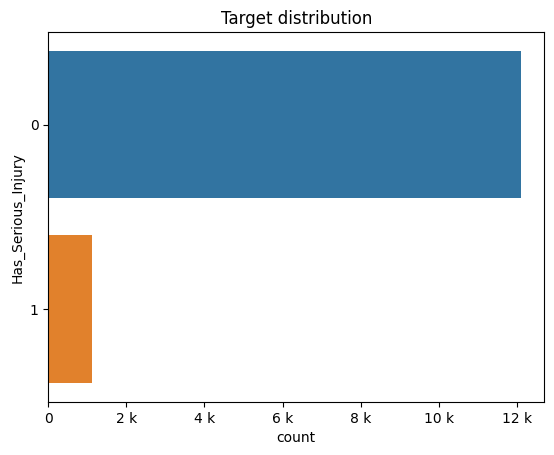

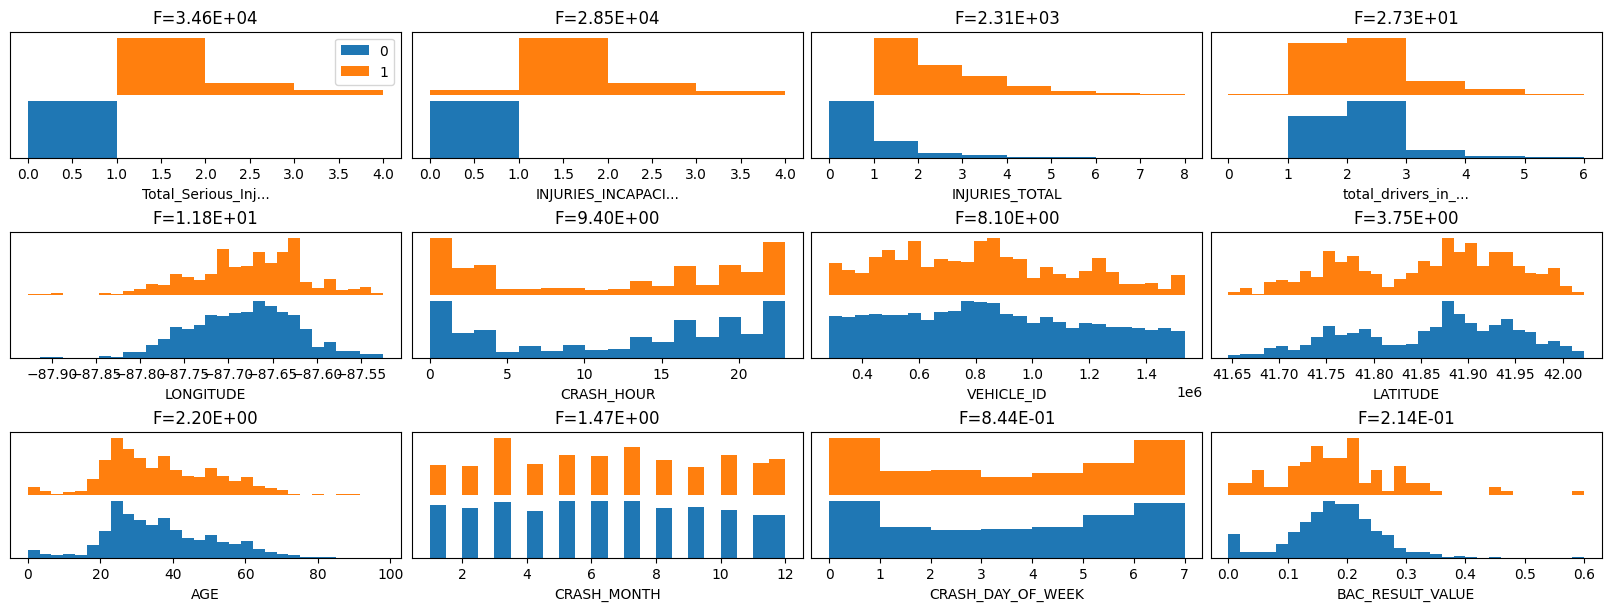

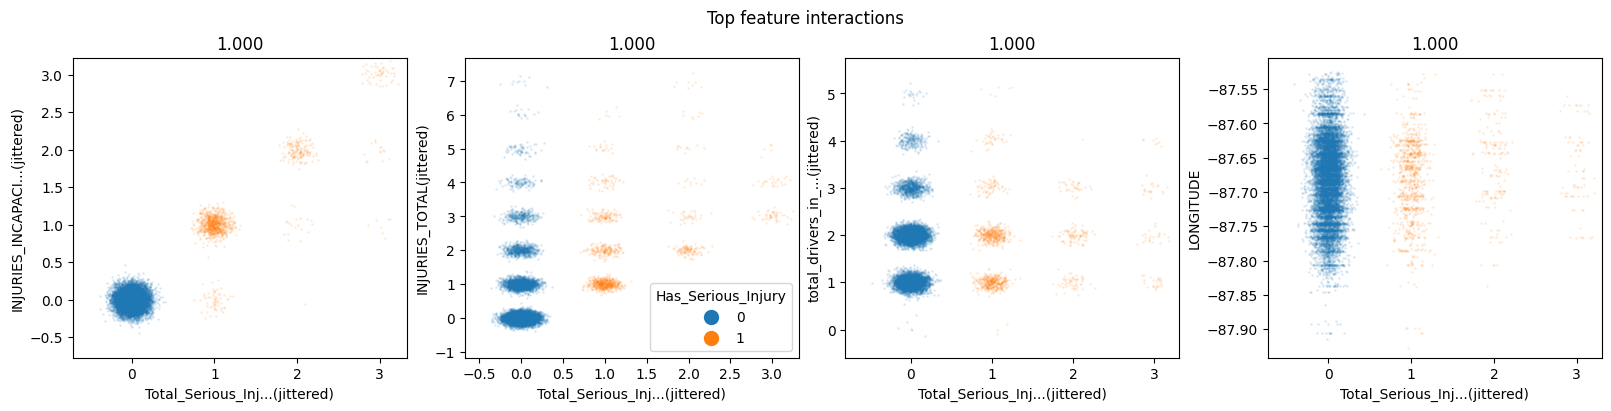

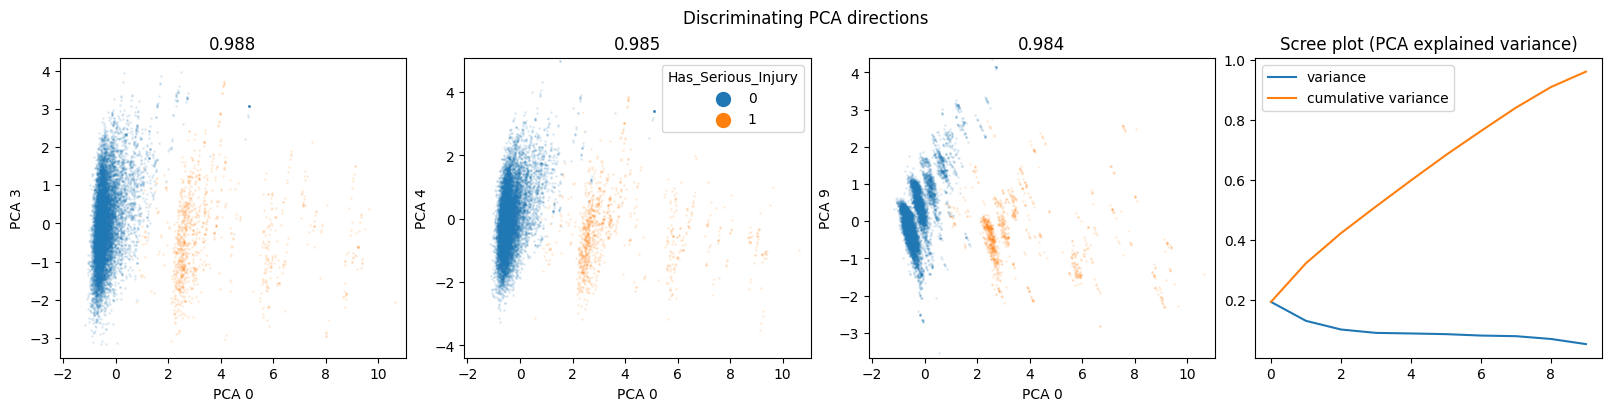

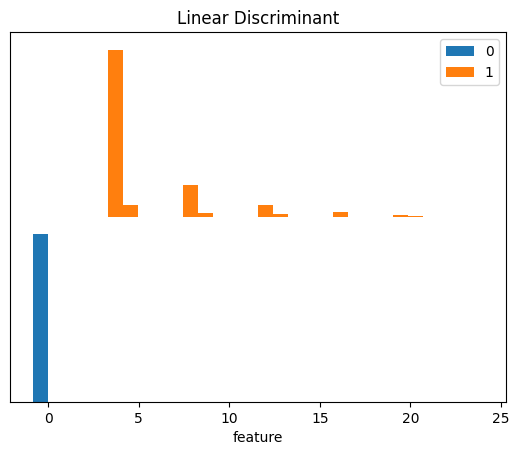

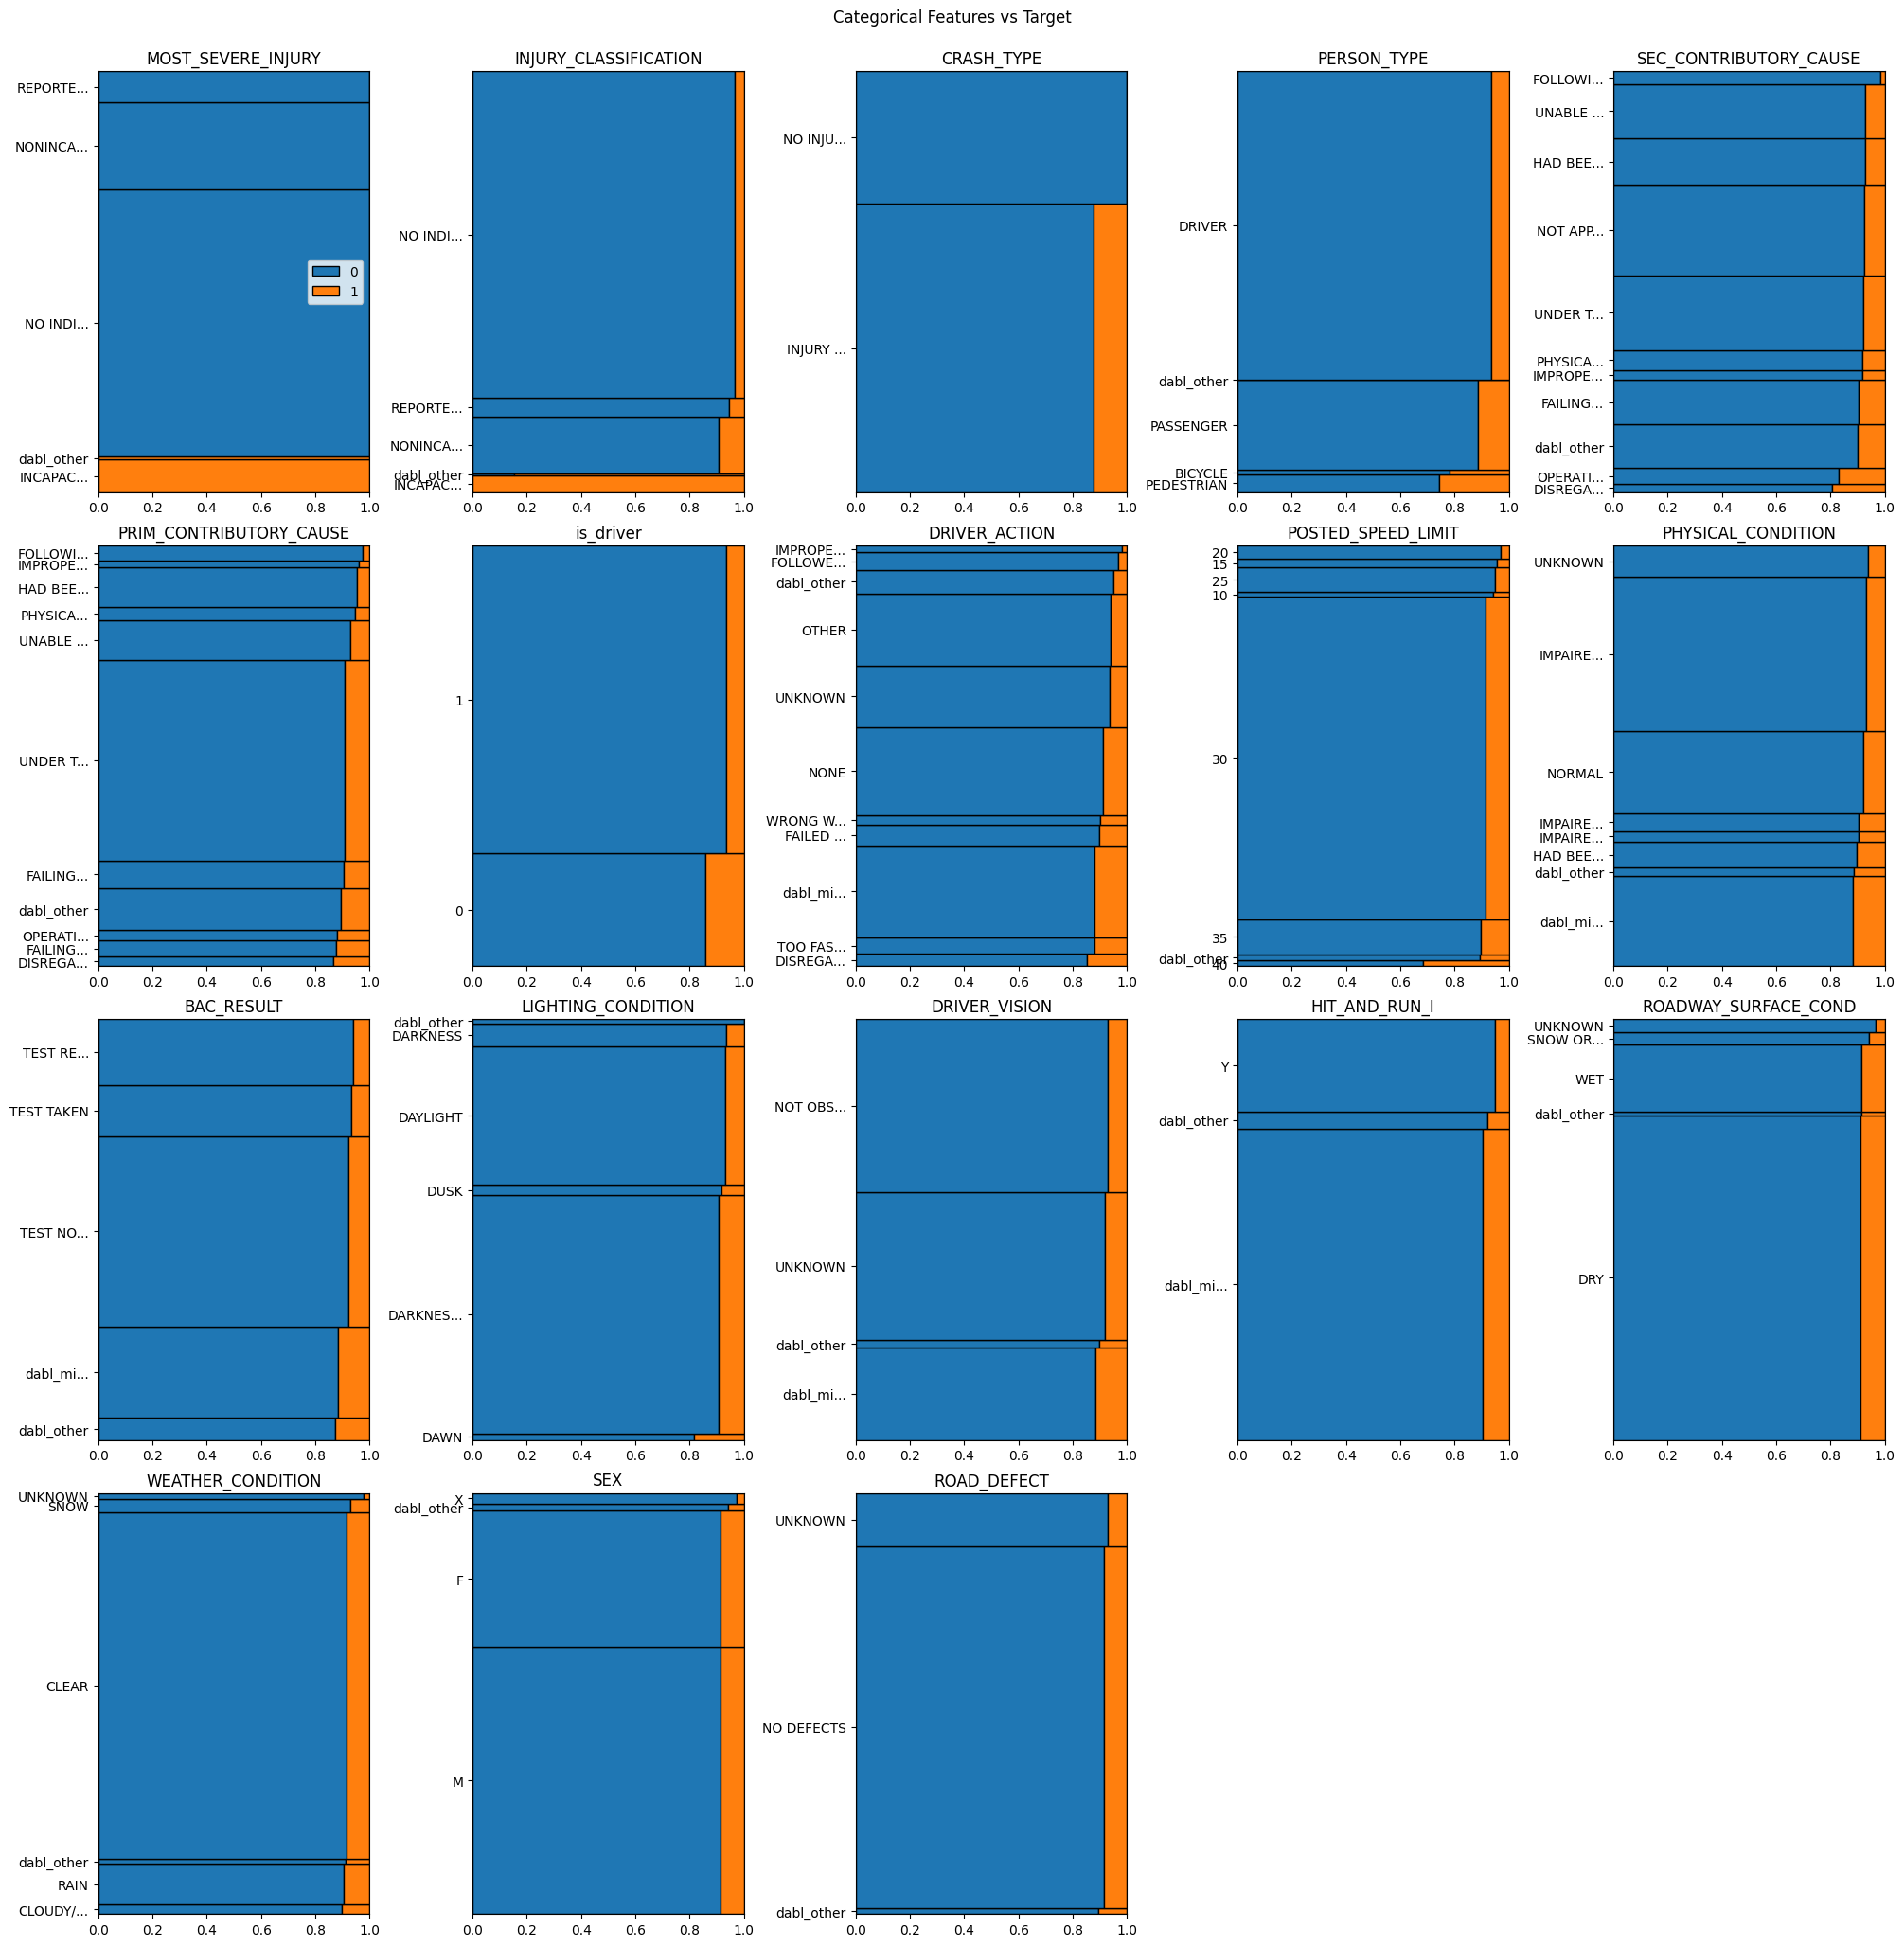

In [157]:
dabl.plot(data, target_col="Has_Serious_Injury")

#Predictive Models

## Handling Missing Data

In [159]:
df['PERSON_TYPE'].isna().sum()

0

In [160]:
df['CRASH_TYPE'].isna().sum()

0

In [161]:
df['DRIVER_ACTION'].isna().sum()

2886

In [162]:
df['DRIVER_ACTION'].value_counts()

NONE                                 2784
OTHER                                2266
UNKNOWN                              1932
FAILED TO YIELD                       653
FOLLOWED TOO CLOSELY                  552
TOO FAST FOR CONDITIONS               525
DISREGARDED CONTROL DEVICES           389
WRONG WAY/SIDE                        285
IMPROPER BACKING                      223
IMPROPER LANE CHANGE                  221
IMPROPER TURN                         196
IMPROPER PASSING                      140
EVADING POLICE VEHICLE                 39
IMPROPER PARKING                       35
CELL PHONE USE OTHER THAN TEXTING      34
OVERCORRECTED                          27
TEXTING                                18
EMERGENCY VEHICLE ON CALL              15
LICENSE RESTRICTIONS                    5
STOPPED SCHOOL BUS                      1
Name: DRIVER_ACTION, dtype: int64

###`X_train`

### `MissingIndicator`

In [188]:
from sklearn.impute import MissingIndicator

# (1) Identify data to be transformed
action_train = X_train[["DRIVER_ACTION"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object on action_train
missing_indicator.fit(action_train)

# (4) Transform action_train and assign the result
# to action_missing_train
action_missing_train = missing_indicator.transform(action_train)


# Visually inspect action_missing_train
action_missing_train

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [189]:
# (5) add the transformed data to the other data
X_train["ACTION_Missing"] = action_missing_train
X_train

,PERSON_ID,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE_,PERSON_TYPE,SEX,AGE,HOSPITAL,INJURY_CLASSIFICATION,DRIVER_ACTION,...,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,LATITUDE,LONGITUDE,LOCATION,Under_Influence,Total_Serious_Injuries,ACTION_Missing
11383,O1328622,7c0afa1bbdb528da1a9a1e5e275793ed50473830c938b1...,1262102.0,2022-05-02 21:34:00,DRIVER,F,41.0,NaN,NO INDICATION OF INJURY,NONE,...,NONINCAPACITATING INJURY,2.0,0.0,0.0,41.839402,-87.675557,POINT (-87.675557141968 41.839402216623),1,0.0,False
1645,P137193,6c1a83a6b822d8877dd1ffc5d1c8211cc988ed6bc7425b...,579292.0,2019-03-20 22:43:00,PASSENGER,M,23.0,WEST SUBURBAN HOSPITAL,NONINCAPACITATING INJURY,NaN,...,NONINCAPACITATING INJURY,1.0,0.0,0.0,41.895248,-87.738516,POINT (-87.738516456106 41.895248307451),1,0.0,True
6432,O419877,457724a1eafcf421b0b35a1312e0f7bb5041f569ab8a8f...,403344.0,2018-06-27 23:22:00,DRIVER,M,27.0,ST ANTHONY,NONINCAPACITATING INJURY,OTHER,...,NONINCAPACITATING INJURY,1.0,0.0,0.0,41.845256,-87.726120,POINT (-87.726119581457 41.84525608273),1,0.0,False
8238,O628817,506bd28f42ce3081e8b0f3c2cdc41e918a237d6a6e8ee7...,598982.0,2019-04-19 22:18:00,DRIVER,F,36.0,REFUSED,NO INDICATION OF INJURY,UNKNOWN,...,NO INDICATION OF INJURY,0.0,0.0,0.0,41.972035,-87.724559,POINT (-87.724559213365 41.972035125474),1,0.0,False
10337,P231170,bd5f255456f6237e82b5a8fe6da931b69015d09c4c5797...,968531.0,2021-01-09 01:05:00,PASSENGER,M,30.0,NaN,NO INDICATION OF INJURY,NaN,...,NO INDICATION OF INJURY,0.0,0.0,0.0,41.951355,-87.747113,POINT (-87.747113158793 41.951354552141),1,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11633,O1392500,68df6569b625972ce4256cc4b3759f94d82865388c11e4...,1323197.0,2022-08-04 17:22:00,DRIVER,M,33.0,NaN,NO INDICATION OF INJURY,TOO FAST FOR CONDITIONS,...,NO INDICATION OF INJURY,0.0,0.0,0.0,41.853968,-87.670870,POINT (-87.67087018817 41.853967880421),1,0.0,False
1344,P126567,6d21d4a7936d7eb1c47b5cb58a0cc713af82cb5b58cfb4...,535296.0,2019-01-11 10:38:00,PASSENGER,M,41.0,NaN,NO INDICATION OF INJURY,NaN,...,NO INDICATION OF INJURY,0.0,0.0,0.0,41.905822,-87.751094,POINT (-87.751093574376 41.905821777078),1,0.0,True
12815,O1513138,8710481c007ca8910e8eac553998578319163d4505991b...,1438630.0,2023-02-07 08:15:00,DRIVER,M,39.0,NaN,NO INDICATION OF INJURY,OTHER,...,NO INDICATION OF INJURY,0.0,0.0,0.0,41.779914,-87.641299,POINT (-87.641298992543 41.779914179134),1,0.0,False
7293,O515342,fe05a01f85fbd60ca1eddc0d71ff7552d02f229aa07d09...,492334.0,2018-11-02 13:25:00,DRIVER,F,33.0,NaN,NO INDICATION OF INJURY,NONE,...,NO INDICATION OF INJURY,0.0,0.0,0.0,41.866212,-87.659227,POINT (-87.659226860982 41.866212287659),1,0.0,False


In [190]:
X_train["DRIVER_ACTION"].fillna("MISSING", inplace=True)

###Select and inspect the columns we want for our model

In [191]:
# features for the model
selected_features = ['CRASH_TYPE','DRIVER_ACTION','PERSON_TYPE', 'Under_Influence']

X_train = X_train[selected_features]

X_test = X_test[selected_features]

##Use `OneHotEncoder` to convert the categorical variables into numeric variables

### `X_train['PERSON_TYPE']`

In [192]:
# (1) Create a variable person_type_train
# extracted from X_train
# (double brackets due to shape expected by OHE)
person_type_train = X_train[["PERSON_TYPE"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse_output=False, handle_unknown="ignore")

# (3) Fit the encoder on person_type_train
ohe.fit(person_type_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['BICYCLE', 'DRIVER', 'NON-CONTACT VEHICLE', 'NON-MOTOR VEHICLE',
        'PASSENGER', 'PEDESTRIAN'], dtype=object)]

In [193]:
# (4) Transform person_type_train using the encoder and
# assign the result to person_type_encoded_train
person_type_encoded_train = ohe.transform(person_type_train)

# Visually inspect person_type_encoded_train
person_type_encoded_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [194]:
# (5a) Make the transformed data into a dataframe
person_type_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
person_type_encoded_train

,BICYCLE,DRIVER,NON-CONTACT VEHICLE,NON-MOTOR VEHICLE,PASSENGER,PEDESTRIAN
11383,0.0,1.0,0.0,0.0,0.0,0.0
1645,0.0,0.0,0.0,0.0,1.0,0.0
6432,0.0,1.0,0.0,0.0,0.0,0.0
8238,0.0,1.0,0.0,0.0,0.0,0.0
10337,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
11633,0.0,1.0,0.0,0.0,0.0,0.0
1344,0.0,0.0,0.0,0.0,1.0,0.0
12815,0.0,1.0,0.0,0.0,0.0,0.0
7293,0.0,1.0,0.0,0.0,0.0,0.0


In [195]:
# (5b) Drop original PERSON_TYPE column
X_train.drop("PERSON_TYPE", axis=1, inplace=True)
# (6) merge
X_train = pd.concat([X_train, person_type_encoded_train], axis=1)

<ipython-input-195-a35ce7f655c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop("PERSON_TYPE", axis=1, inplace=True)


### Repeat these steps for the `X_test['PERSON_TYPE]` set (except for fitting of course!)

In [196]:
# (1) Create a variable person_type_test
# extracted from X_test
# (double brackets due to shape expected by OHE)
person_type_test = X_test[["PERSON_TYPE"]]

#  (2) Transform person_type_test using the encoder and
# assign the result to person_type_encoded_test
person_type_encoded_test = ohe.transform(person_type_test)

# Visually inspect person_type_encoded_test
person_type_encoded_test

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [197]:
# (3a) Make the transformed data into a dataframe
person_type_encoded_test= pd.DataFrame(
    # Pass in NumPy array
    person_type_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# Visually inspect new dataframe
person_type_encoded_test

,BICYCLE,DRIVER,NON-CONTACT VEHICLE,NON-MOTOR VEHICLE,PASSENGER,PEDESTRIAN
8920,0.0,1.0,0.0,0.0,0.0,0.0
11353,0.0,0.0,0.0,0.0,1.0,0.0
4027,0.0,0.0,0.0,0.0,1.0,0.0
8944,0.0,1.0,0.0,0.0,0.0,0.0
8120,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
8442,0.0,0.0,0.0,0.0,0.0,1.0
8519,0.0,1.0,0.0,0.0,0.0,0.0
4626,0.0,1.0,0.0,0.0,0.0,0.0
5322,0.0,0.0,0.0,0.0,1.0,0.0


In [198]:
# (3b) Drop original PERSON_TYPE column
X_test.drop("PERSON_TYPE", axis=1, inplace=True)
# (4) merge
X_test = pd.concat([X_test, person_type_encoded_test], axis=1)

###`X_train['CRASH_TYPE']`

In [199]:
# (1) Create a variable crash_type_train
# extracted from X_train
# (double brackets due to shape expected by OHE)
crash_type_train = X_train[["CRASH_TYPE"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
#ohe = OneHotEncoder(categories="auto", sparse_output=False, handle_unknown="ignore")

# (3) Fit the encoder on crash_type_train
ohe.fit(crash_type_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['INJURY AND / OR TOW DUE TO CRASH', 'NO INJURY / DRIVE AWAY'],
       dtype=object)]

In [200]:
# (4) Transform crash_type_train using the encoder and
# assign the result to crash_type_encoded_train
crash_type_encoded_train = ohe.transform(crash_type_train)

# Visually inspect crash_type_encoded_train
crash_type_encoded_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [201]:
# (5a) Make the transformed data into a dataframe
crash_type_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    crash_type_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
crash_type_encoded_train

,INJURY AND / OR TOW DUE TO CRASH,NO INJURY / DRIVE AWAY
11383,1.0,0.0
1645,1.0,0.0
6432,1.0,0.0
8238,1.0,0.0
10337,1.0,0.0
...,...,...
11633,1.0,0.0
1344,0.0,1.0
12815,0.0,1.0
7293,0.0,1.0


In [202]:
# (5b) Drop original CRASH_TYPE column
X_train.drop("CRASH_TYPE", axis=1, inplace=True)
# (6) merge
X_train = pd.concat([X_train, crash_type_encoded_train], axis=1)

### Repeat these steps for the `X_test['CRASH_TYPE]` set (except for fitting of course!)

In [203]:
# (1) Create a variable crash_type_test
# extracted from X_test
# (double brackets due to shape expected by OHE)
crash_type_test = X_test[["CRASH_TYPE"]]

#  (2) Transform crash_type_test using the encoder and
# assign the result to crash_type_encoded_test
crash_type_encoded_test = ohe.transform(crash_type_test)

# Visually inspect crash_type_encoded_test
crash_type_encoded_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [204]:
# (3a) Make the transformed data into a dataframe
crash_type_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    crash_type_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# Visually inspect new dataframe
crash_type_encoded_test

,INJURY AND / OR TOW DUE TO CRASH,NO INJURY / DRIVE AWAY
8920,0.0,1.0
11353,1.0,0.0
4027,1.0,0.0
8944,1.0,0.0
8120,1.0,0.0
...,...,...
8442,1.0,0.0
8519,1.0,0.0
4626,0.0,1.0
5322,1.0,0.0


In [205]:
# (3b) Drop original CRASH_TYPE column
X_test.drop("CRASH_TYPE", axis=1, inplace=True)
# (4) merge
X_test = pd.concat([X_test, crash_type_encoded_test], axis=1)

### `X_train['DRIVER_ACTION']`

In [206]:
# (1) Create a variable driver_action_train
# extracted from X_train
# (double brackets due to shape expected by OHE)
driver_action_train = X_train[["DRIVER_ACTION"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
#ohe = OneHotEncoder(categories="auto", sparse_output=False, handle_unknown="ignore")

# (3) Fit the encoder on driver_action_train
ohe.fit(driver_action_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['CELL PHONE USE OTHER THAN TEXTING', 'DISREGARDED CONTROL DEVICES',
        'EMERGENCY VEHICLE ON CALL', 'EVADING POLICE VEHICLE',
        'FAILED TO YIELD', 'FOLLOWED TOO CLOSELY', 'IMPROPER BACKING',
        'IMPROPER LANE CHANGE', 'IMPROPER PARKING', 'IMPROPER PASSING',
        'IMPROPER TURN', 'LICENSE RESTRICTIONS', 'MISSING', 'NONE',
        'OTHER', 'OVERCORRECTED', 'STOPPED SCHOOL BUS', 'TEXTING',
        'TOO FAST FOR CONDITIONS', 'UNKNOWN', 'WRONG WAY/SIDE'],
       dtype=object)]

In [207]:
# (4) Transform driver_action_train using the encoder and
# assign the result to driver_action_encoded_train
driver_action_encoded_train = ohe.transform(driver_action_train)

# Visually inspect driver_action_encoded_train
driver_action_encoded_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [208]:
# (5a) Make the transformed data into a dataframe
driver_action_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    driver_action_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train.index
)

# Visually inspect new dataframe
driver_action_encoded_train

,CELL PHONE USE OTHER THAN TEXTING,DISREGARDED CONTROL DEVICES,EMERGENCY VEHICLE ON CALL,EVADING POLICE VEHICLE,FAILED TO YIELD,FOLLOWED TOO CLOSELY,IMPROPER BACKING,IMPROPER LANE CHANGE,IMPROPER PARKING,IMPROPER PASSING,...,LICENSE RESTRICTIONS,MISSING,NONE,OTHER,OVERCORRECTED,STOPPED SCHOOL BUS,TEXTING,TOO FAST FOR CONDITIONS,UNKNOWN,WRONG WAY/SIDE
11383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
# (5b) Drop original DRIVER_ACTION column
X_train.drop("DRIVER_ACTION", axis=1, inplace=True)
# (6) merge
X_train = pd.concat([X_train, driver_action_encoded_train], axis=1)

### Repeat these steps for the `X_test['DRIVER_ACTION]` set (except for fitting of course!)

In [211]:
# (1) Create a variable driver_action_test
# extracted from X_test
# (double brackets due to shape expected by OHE)
driver_action_test = X_test[["DRIVER_ACTION"]]

#  (2) Transform driver_action_test using the encoder and
# assign the result to driver_action_test
driver_action_encoded_test = ohe.transform(driver_action_test)

# Visually inspect crash_type_encoded_test
driver_action_encoded_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [212]:
# (3a) Make the transformed data into a dataframe
driver_action_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    driver_action_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_test's index
    index=X_test.index
)

# Visually inspect new dataframe
driver_action_encoded_test

,CELL PHONE USE OTHER THAN TEXTING,DISREGARDED CONTROL DEVICES,EMERGENCY VEHICLE ON CALL,EVADING POLICE VEHICLE,FAILED TO YIELD,FOLLOWED TOO CLOSELY,IMPROPER BACKING,IMPROPER LANE CHANGE,IMPROPER PARKING,IMPROPER PASSING,...,LICENSE RESTRICTIONS,MISSING,NONE,OTHER,OVERCORRECTED,STOPPED SCHOOL BUS,TEXTING,TOO FAST FOR CONDITIONS,UNKNOWN,WRONG WAY/SIDE
8920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
# (3b) Drop original "DRIVER_ACTION column
X_test.drop("DRIVER_ACTION", axis=1, inplace=True)
# (4) merge
X_test = pd.concat([X_test, driver_action_encoded_test], axis=1)

##And now the Decision Tree!

In [215]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=10)

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=10)

## Predictions and Evaluation

In [216]:
y_pred = tree_clf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [217]:
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

Accuracy: 92.31932264892652


In [218]:
# Accuracy on training data
tree_clf.score(X_train, y_train)

0.9121887287024901

In [219]:
# Accuracy on test data
tree_clf.score(X_test, y_test)

0.9231932264892652

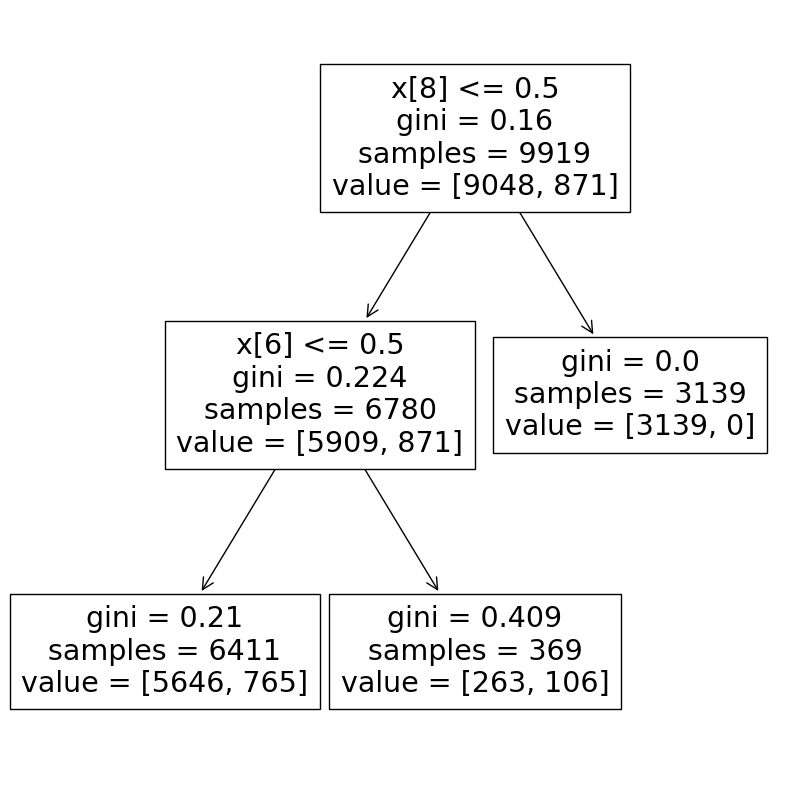

In [220]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_clf, ax=ax);

In [221]:
#  root node
print(X_train.columns[8])

NO INJURY / DRIVE AWAY


In [222]:
# left decision node under root node [8] NO INJURY / DRIVE AWAY
print(X_train.columns[6])

PEDESTRIAN


In [223]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


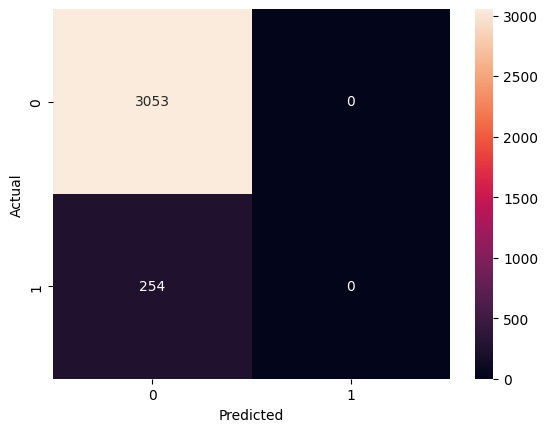

In [224]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# SMOTE + Random Forest

##Take 1

In [225]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 10)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 871
Before OverSampling, counts of label '0': 9048 

After OverSampling, the shape of train_X: (18096, 30)
After OverSampling, the shape of train_y: (18096,) 

After OverSampling, counts of label '1': 9048
After OverSampling, counts of label '0': 9048


In [226]:
from sklearn.ensemble import RandomForestClassifier

# create a Random Forest model
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=10)

# train the model
clf.fit(X_train_res, y_train_res)

# make predictions
y_pred = clf.predict(X_test)


In [227]:
# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

Precision: 0.11130587204206836
Recall: 1.0
F1 Score: 0.20031545741324921


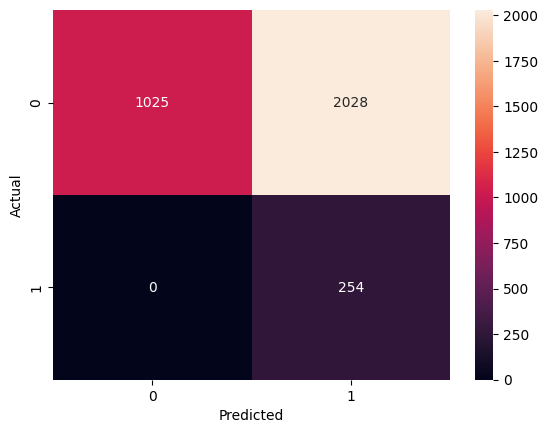

In [228]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


* TP = 254
* TN = 1025
* FP = 2028
* FN = 0

##Take 2 (SPOILER ALERT: same result inside!)

##Undersampling the majority class

In [229]:
from imblearn.under_sampling import RandomUnderSampler


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


rus = RandomUnderSampler(random_state=10)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print('After UnderSampling, the shape of train_X: {}'.format(X_train_under.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_under.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_under == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_under == 0)))


Before UnderSampling, counts of label '1': 871
Before UnderSampling, counts of label '0': 9048 

After UnderSampling, the shape of train_X: (1742, 30)
After UnderSampling, the shape of train_y: (1742,) 

After UnderSampling, counts of label '1': 871
After UnderSampling, counts of label '0': 871


In [230]:
from sklearn.ensemble import RandomForestClassifier

# create a Random Forest model
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=10)

# train the model
clf.fit(X_train_under, y_train_under)

# make predictions
y_pred = clf.predict(X_test)

In [231]:
# Precision
precision = precision_score(y_test, y_pred)
print("Precision: {0}".format(precision))

# Recall
recall = recall_score(y_test, y_pred)
print("Recall: {0}".format(recall))

# F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1))

Precision: 0.11130587204206836
Recall: 1.0
F1 Score: 0.20031545741324921


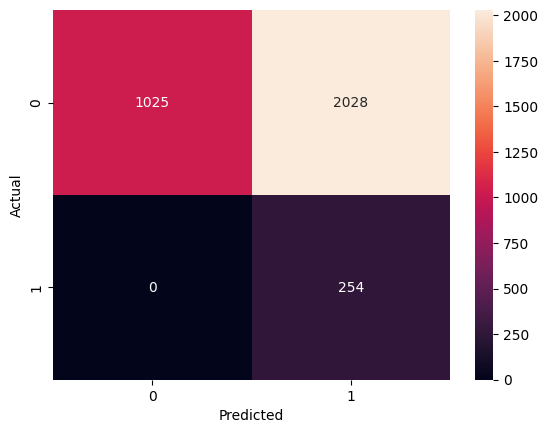

In [232]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


##ROC

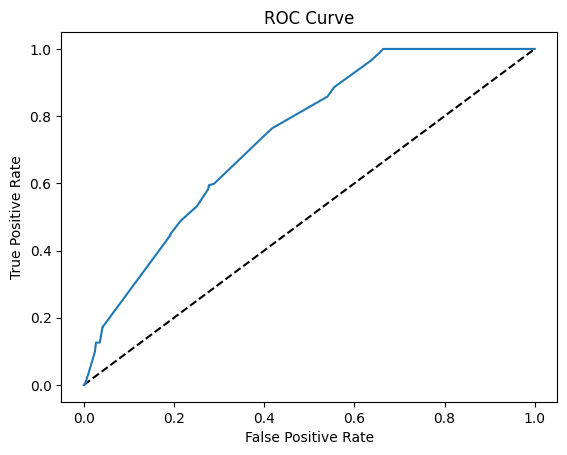

AUC: 0.7390433057970602


In [233]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


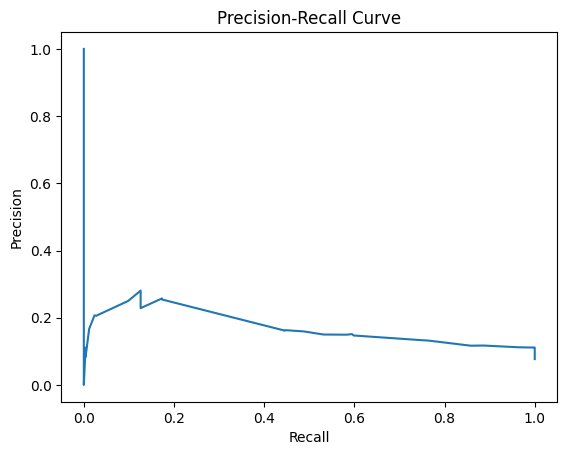

In [234]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

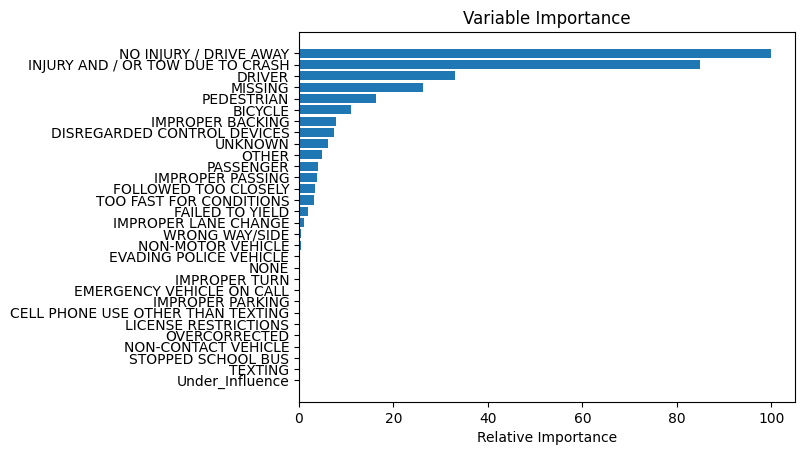

In [235]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
